# Deep Learning with TensorFlow/Keras

Now that we have completed a project of Machine Learning with spark ML, in this assignment, we will be swithing to the context of Deep Learning with Tensorflow/Keras by two tasks:
- Task1: Image Classification with CNN
- Task2: Image captioning with a combination of CNN and RNN

## Task 1: Going Deeper with convolutions


Before **Inception v1** (**GoogLeNet**), which is the winner of the **ILSVRC** (ImageNet Large Scale Visual Recognition Competition) in 2014, most popular CNNs just stacked convolution layers deeper and deeper, hoping to get better performance.
The Inception network, however, uses a lot of tricks to improve performance in terms of speed and accuracy.
Compared to other networks, **Inception v1** has significant improvement over **ZFNet** (the winner in 2013) and **AlexNet** (the winner in 2012), and has relatively lower error rate compared with the VGGNet.

In this task, we will be implementing the inception architecture [in this paper](https://arxiv.org/abs/1409.4842) with TensorFlow/Keras. 

The goal of this task is to understand how to write code to build the model, as long as you can verify the correctness of the code (e.g., through Keras model summary), it is not necessary to train the model.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import datetime
%load_ext tensorboard

In [2]:
class InceptionBlock(tf.keras.layers.Layer):
    def __init__(self,
                 conv_one, 
                 red_conv_three, conv_three, 
                 red_conv_five, conv_five,
                 pool,
                 name="inception"):
        super(InceptionBlock, self).__init__(name=name)
        
        self.conv_one = conv_one
        self.red_conv_three, self.conv_three = red_conv_three, conv_three, 
        self.red_conv_five, self.conv_five = red_conv_five, conv_five,
        self.pool = pool
        
    def build(self, input_shape):
         with tf.name_scope(self.name):
            self.conv_one_layer = tf.keras.layers.Conv2D(kernel_size=1, filters=self.conv_one, activation = 'relu', padding = 'same', input_shape=input_shape, name='conv1l')

            self.red_conv_three_layer = tf.keras.layers.Conv2D(kernel_size=1, filters=self.red_conv_three, activation = 'relu', padding = 'same', input_shape=input_shape, name='redConv3l')
            self.conv_three_layer = tf.keras.layers.Conv2D(kernel_size=3, filters=self.conv_three, activation = 'relu', padding = 'same', name='conv3l')

            self.red_conv_five_layer = tf.keras.layers.Conv2D(kernel_size=1, filters=self.red_conv_five, activation = 'relu', padding = 'same', input_shape=input_shape, name='redConv5l')
            self.conv_five_layer = tf.keras.layers.Conv2D(kernel_size=5, filters=self.conv_five, activation = 'relu', padding = 'same', name='conv5l')

            self.pooling_layer = tf.keras.layers.MaxPooling2D(pool_size=3, strides=1, padding = 'same', input_shape=input_shape, name='pool')
            self.red_pooling_layer = tf.keras.layers.Conv2D(kernel_size=1, filters=self.pool, activation = 'relu', padding = 'same', name='redPool')

            self.concat_layer = keras.layers.Concatenate(axis=-1, name='concat')
        
    def call(self, input_tensor):
        x_conv1 = self.conv_one_layer(input_tensor)
        
        x_conv3 = self.red_conv_three_layer(input_tensor)
        x_conv3 = self.conv_three_layer(x_conv3)
        
        x_conv5 = self.red_conv_five_layer(input_tensor)
        x_conv5 = self.conv_five_layer(x_conv5)
        
        x_pool = self.pooling_layer(input_tensor)
        x_pool = self.red_pooling_layer(x_pool)
        
        return self.concat_layer([x_conv1, x_conv3, x_conv5, x_pool])

In [3]:
class AuxClassifier(tf.keras.layers.Layer):
    def __init__(self, name="auxClf"):
        super(AuxClassifier, self).__init__(name=name)
    
    def build(self, input_shape):
        with tf.name_scope(self.name):
            self.avgPool = tf.keras.layers.AveragePooling2D(pool_size=5, strides=3, padding='same', input_shape=input_shape, name='avgPool')
            self.conv = tf.keras.layers.Conv2D(kernel_size=1, filters=128, activation='relu', padding='same', name='conv')
            self.denseRelu = tf.keras.layers.Dense(1024, activation='relu', name='denseRelu')
            self.dropout = tf.keras.layers.Dropout(rate=0.7, name='dropout')
            self.flatten = tf.keras.layers.Flatten(name='flatten')
            self.denseSoftmax = tf.keras.layers.Dense(1000, activation='softmax', name='denseSoftmax')
        
    def call(self, input_tensor, training=False):
        x = self.avgPool(input_tensor)
        x = self.conv(x)
        x = self.denseRelu(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.denseSoftmax(x)

        return x

In [4]:
inception_in = tf.keras.layers.Input(shape=[224, 224, 3], name='inception_in')

x = tf.keras.layers.Conv2D(kernel_size=7, filters=64, strides=2, activation='relu', padding='same', name='conv1')(inception_in)
x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same', name='pool1')(x)
x = tf.keras.layers.Conv2D(kernel_size=1, filters=64, activation='relu', padding='same', name='conv2')(x)
x = tf.keras.layers.Conv2D(kernel_size=3, filters=192, activation='relu', padding='same', name='conv3')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same', name='pool2')(x)

x = InceptionBlock(conv_one=64,
               red_conv_three=96, conv_three=128,
               red_conv_five=16, conv_five=32,
               pool=32,
               name='inception1')(x)

x = InceptionBlock(conv_one=128,
               red_conv_three=128, conv_three=192,
               red_conv_five=32, conv_five=96,
               pool=64,
               name='inception2')(x)

x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same', name='pool3')(x)

x = InceptionBlock(conv_one=192,
               red_conv_three=96, conv_three=208,
               red_conv_five=16, conv_five=48,
               pool=64,
               name='inception3')(x)

auxClf1 = AuxClassifier(name='auxClf1')(x)


x = InceptionBlock(conv_one=160,
               red_conv_three=112, conv_three=224,
               red_conv_five=24, conv_five=64,
               pool=64,
               name='inception4')(x)

x = InceptionBlock(conv_one=128,
               red_conv_three=128, conv_three=256,
               red_conv_five=24, conv_five=64,
               pool=64,
               name='inception5')(x)

x = InceptionBlock(conv_one=112,
               red_conv_three=144, conv_three=288,
               red_conv_five=32, conv_five=64,
               pool=64,
               name='inception6')(x)

auxClf2 = AuxClassifier(name='auxClf2')(x)

x = InceptionBlock(conv_one=256,
                       red_conv_three=160, conv_three=320,
                       red_conv_five=32, conv_five=128,
                       pool=128,
                       name='inception7')(x)

x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same', name='pool4')(x)

x = InceptionBlock(conv_one=256,
                       red_conv_three=160, conv_three=320,
                       red_conv_five=32, conv_five=128,
                       pool=128,
                       name='inception8')(x)

x = InceptionBlock(conv_one=384,
                       red_conv_three=192, conv_three=384,
                       red_conv_five=48, conv_five=128,
                       pool=128,
                       name='inception9')(x)

x = tf.keras.layers.AveragePooling2D(pool_size=7, strides=1, name='pool5')(x)
x = tf.keras.layers.Dropout(rate=0.4, name='dropout')(x)
inception_out = tf.keras.layers.Dense(1000, activation='softmax', name='inception_out')(x)

inceptionCNN = tf.keras.Model(inputs=inception_in, outputs=[inception_out, auxClf1, auxClf2])

In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
mse_loss_fn = tf.keras.losses.MeanSquaredError()

# train_dataset = tfds.load(name='imagenet2012', split='train')

x_train = tf.zeros([2, 224, 224, 3])
y_train = tf.zeros([2, 1000])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

inceptionCNN.compile(optimizer,
                     loss={"inception_out": tf.keras.losses.MeanSquaredError(),
                           "auxClf1": tf.keras.losses.MeanSquaredError(),
                           "auxClf2": tf.keras.losses.MeanSquaredError()}
                    )

!rm -rf ./logs/
logdir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

# _ = inceptionCNN(x_train)
# inceptionCNN.summary()
inceptionCNN.fit(x_train, 3*[y_train], epochs=1, batch_size=2, callbacks=[tensorboard_callback])

Train on 2 samples
2/2 [==============================] - 9s 5s/sample - loss: 3.0000e-06 - inception_out_loss: 1.0000e-06 - auxClf1_loss: 1.0000e-06 - auxClf2_loss: 1.0000e-06


In [6]:
%tensorboard --logdir logs/fit

## Task 2: Show and Tell: A Neural Image Caption Generator

Automatically describing the content of an image is a fundamental problem in AI that connects *computer vision* and *natural language processing*.
In this task, we will be looking into how we can use CNNs and RNNs to build an Image Caption Generator.

Specifically, you will be implementing and training the model [in this paper](https://arxiv.org/abs/1411.4555) with TensorFlow/Keras on one of the datasets mentioned in the paper.

To lighten the burden on training the network, you can use any pretrained network in [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications).

In [7]:
import tensorflow as tf
import os
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pickle
import json
import time
from IPython.display import Image, display

### Prepare the data

**Warning** executing the next cell will trigger the download of a **13GB** dataset (MS-COCO)

In [8]:
annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'

name_of_zip = 'train2014.zip'
if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
    image_zip = tf.keras.utils.get_file(name_of_zip,
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
    PATH = os.path.dirname(image_zip)+'/train2014/'
else:
    PATH = os.path.abspath('.')+'/train2014/'

In [9]:
# Read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# Select the first 30000 captions from the shuffled set
num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [10]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [11]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [7]:
# from tqdm import tqdm

# # Get unique images
# encode_train = sorted(set(img_name_vector))

# # Feel free to change batch_size according to your system configuration
# image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# image_dataset = image_dataset.map(
#   load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# for img, path in image_dataset:
#     batch_features = image_features_extract_model(img)
#     batch_features = tf.reshape(batch_features,
#                               (batch_features.shape[0], -1, batch_features.shape[3]))

#     for bf, p in zip(batch_features, path):
#         path_of_feature = p.numpy().decode("utf-8")
#         np.save(path_of_feature, bf.numpy())

In [12]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [13]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [14]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [15]:
# Feel free to change these parameters according to your system's configuration
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 128
units = 256
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
max_length = cap_vector.shape[1]

In [16]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [17]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Define the model

In [18]:
# Since we already cached the extracted features, we just need
# a dense layer to match the embedding dimensions
class Image_Encoder(tf.keras.layers.Layer):
    def __init__(self, embedding_dim):
        super(Image_Encoder, self).__init__()
        self.flat = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(embedding_dim, activation='relu')
    
    def call(self, features):
        x = self.flat(features)
        x = self.fc(x)
        return x

In [19]:
class LSTM_Decoder(tf.keras.Model):
    def __init__(self, units, vocab_size):
        super(LSTM_Decoder, self).__init__()
        self.units = units
        
        self.lstm = tf.keras.layers.LSTMCell(units, recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
    
    def call(self, inputs, states):
        outputs, states_nxt = self.lstm(inputs, states)
        x = self.fc(outputs)
        return x, states_nxt
    
    def get_initial_state(self, inputs):
        return self.lstm.get_initial_state(inputs=inputs)

### Train the model

In [20]:
img_encoder = Image_Encoder(embedding_dim)
txt_encoder = tf.keras.layers.Embedding(vocab_size, embedding_dim)
lstm_decoder = LSTM_Decoder(units, vocab_size)

In [21]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [22]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(img_encoder=img_encoder,
                           txt_encoder=txt_encoder,
                           lstm_decoder=lstm_decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [23]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [26]:
@tf.function
def train_step(image, caption):
    loss = 0
    
    with tf.GradientTape() as tape:
        dec_input = img_encoder(image)
        dec_states = lstm_decoder.get_initial_state(dec_input)
        _, dec_states = lstm_decoder(dec_input, dec_states)
        for i in range(caption.shape[1]-1):
            dec_input = txt_encoder(caption[:, i])
            # passing the features through the decoder
            prediction, dec_states = lstm_decoder(dec_input, dec_states)

            loss += loss_function(caption[:, i+1], prediction)

    total_loss = (loss / int(caption.shape[1]))

    trainable_variables = img_encoder.trainable_variables + \
                          txt_encoder.trainable_variables + \
                          lstm_decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [37]:
EPOCHS = 5

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (image, caption)) in enumerate(dataset):
        batch_loss, t_loss = train_step(image, caption)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(caption.shape[1])))

    ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [24]:
def gen_caption(image):
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    img_input = img_encoder(img_tensor_val)

    nxt_word = tf.Variable([tokenizer.word_index['<start>']])
    dec_states = lstm_decoder.get_initial_state(img_input)
    
    result = ['<start>']
    _, dec_states = lstm_decoder(img_input, dec_states)
    for i in range(max_length):
        dec_input = txt_encoder(nxt_word)
        nxt_word, dec_states = lstm_decoder(dec_input, dec_states)
        
        predicted_id = tf.random.categorical(nxt_word, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])
        nxt_word = tf.Variable([predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result
    
    return result

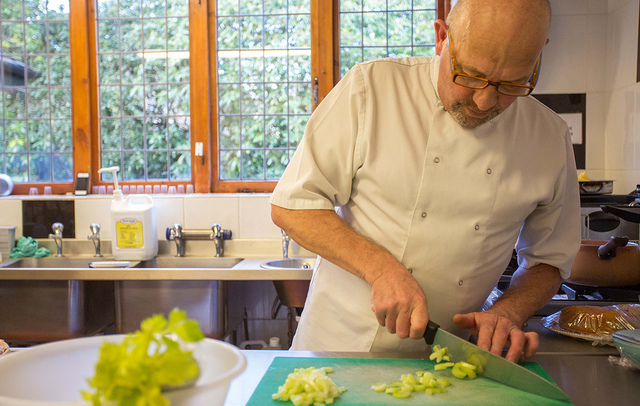

Real Caption: a guy with glasses in a chef outfit chopping up vegetables
Prediction Caption: a collection of <unk> bikes asleep and print legs at a person's ball


In [29]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result = gen_caption(image)

display(Image(filename=image))
print ('Real Caption:', *real_caption.split()[1:-1])
print ('Prediction Caption:', ' '.join(result[1:-1]))